In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [139]:
# Save references to each table
measurements = base.classes.measurement
stations = base.classes.station

In [140]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [141]:
# Find the most recent date in the data set.
recent_date = session.query(measurements.date).order_by(measurements.date.desc()).first()
recent_date

('2017-08-23',)

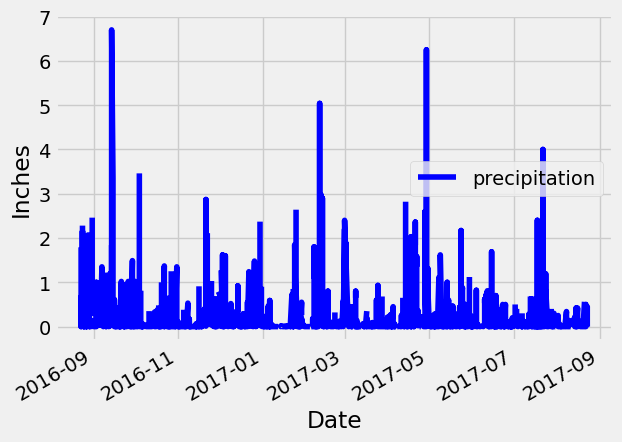

In [150]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
precipitations = session.query(measurements.prcp).group_by(measurements.date).order_by(measurements.date.desc())

# Calculate the date one year from the last date in data set.
latest_str =list(np.ravel(recent_date))[0]
latest_date=dt.datetime.strptime(latest_str,"%Y-%m-%d")
last_date=latest_date-dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
date_and_prcp = session.query(measurements.prcp,measurements.date).order_by(measurements.date.desc()).\
    filter(measurements.date>=last_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(date_and_prcp,columns=['precipitation','date'])

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])
sorted_df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(x='date', y='precipitation', color='blue',legend=True,grid=True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [143]:
# Use Pandas to calculate the summary statistics for the precipitation data
date_and_prcp = session.query(measurements.prcp,measurements.date).order_by(measurements.date.desc()).\
    filter(measurements.date>=last_date).all()
df = pd.DataFrame(date_and_prcp,columns=['precipitation','date'])
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [144]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(stations.station)).all()

[(9,)]

In [145]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(measurements.station,func.count(measurements.station)).group_by(measurements.station).order_by(func.count(measurements.station).desc()).all()                                                                                                    

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [158]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(measurements.station, func.count(measurements.station)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).\
    first()
active_station_str = result[0]
session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
             filter(measurements.station==active_station_str).all()

[(54.0, 85.0, 71.66378066378067)]

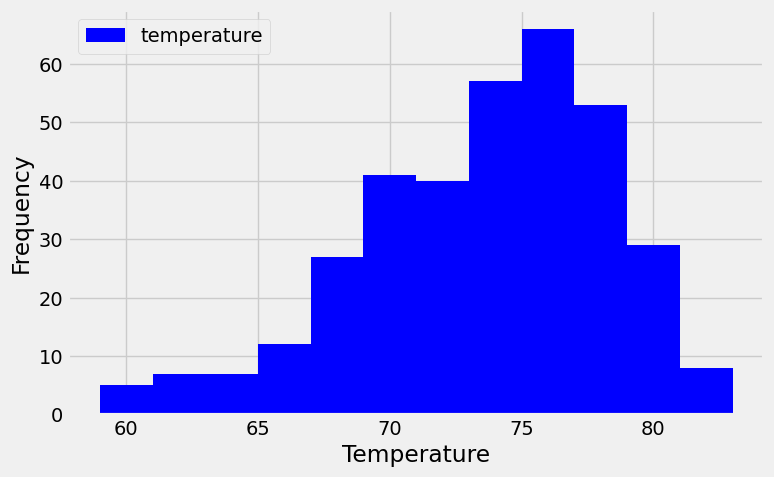

In [149]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurements.tobs, measurements.date).\
    filter(measurements.station == active_station_str, measurements.date >= last_date).all()

# Create a DataFrame from the result
temperature_df = pd.DataFrame(temperature_data, columns=['temperature', 'date'])
temperature_df['date'] = pd.to_datetime(temperature_df['date'])

# Plot histogram
histogram = temperature_df['temperature'].hist(bins=12, figsize=(8, 5), color='b', zorder=2, legend=True)

# Set labels
histogram.set_ylabel("Frequency")
histogram.set_xlabel("Temperature")

# Show the plot
plt.show()

# Close Session

In [148]:
# Close Session
session.close()